In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import os
import sys
from Line import Line
from moviepy.editor import VideoFileClip

#set video or image mode
mode = 'video'
#images directory
img_dir = 'test_images/'
img_out_dir = 'output_images/'
#videos directory
video_dir = 'project_videos/project_video.mp4'
video_dir_out = 'output_videos/project_video.mp4'

#calibration settings
calibrate_img_dir = 'camera_cal/' #directory of calibration images
chess_size = (9, 6) #size of chessboard in calibration images
mtx = np.ndarray(shape=(3,3)) #setting camera matrix as global variables
dist = np.ndarray(shape=(1,5))  #setting distortion coefficients as global variables

#perspective transform settings 
#These points were obtained manually
source_points = np.float32([ [594, 450], [685, 450], [280, 675], [1040, 675] ])
destination_points = np.float32([ [320, 0], [960, 0], [320, 720], [960, 720] ])

#lane finding settins
#type of sliding window, convolution or regular
slide_mode = 'convolution'

#Create instance of line class
myLine = Line()

def calibrate(directory, size):
    #This functions return the camera matrix and distortion coefficients by perfroming calibration on a set of chessboard images
    #obtaining files in directory
    cal_files = os.listdir(directory)

    #defining image and object points
    img_points = []
    obj_points = []
    objp = np.zeros((size[0]*size[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:size[0], 0:size[1]].T.reshape(-1,2)

    #iterating over images in directory 
    for file in cal_files:
        
        #reading image
        if(file[-3:]=="jpg"):
            cal_img = mpimg.imread(directory + file)

            #converting to grayscale
            gray = cv2.cvtColor(cal_img, cv2.COLOR_RGB2GRAY)

            #obtaining corners in chessboard
            ret, corners = cv2.findChessboardCorners(gray, size)
            if (ret):
                img_points.append(corners)
                obj_points.append(objp)

    #performing calibration
    ret, cam_mtx, dist_coef, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

    return cam_mtx, dist_coef


def undistort(img, camera_mtx, dist_coef):
    #return undistorted images based on camera matrix and distortion coefficients
    return cv2.undistort(img, camera_mtx, dist_coef)

def perspective_transform(img, src, dst):
    #This function perform perspective transform based on source and destination points

    #obtain transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)

    #performing and returning perspective transform
    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)


def region_masking(input_image, vertices):
    #This function returns a specific region of the input image based on the provided vertices212121

    #defining a blank mask to start with
    mask = np.zeros_like(input_image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(input_image.shape) > 2:
        channel_count = input_image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(input_image, mask)

    return masked_image
 

def threshold(img):
    #This function performs dynamic thresholding by returning the pixels with the highest sobel in a specified direction as well as 
    #pixel with highest saturation and lightness in a specified region of an image 
    
    #defining image and thresholding characteristics
    height, width = img.shape[0:2]
    n_pxl = height*width
    s_cut_off_percent = 0.4 #percentage of pixels with the highest saturation to select
    l_cut_off_percent = 12 #percentage of pixels with the highest lightness to select
    sobel_dir_thresh=(0.7, 1.3) #range of direction of the sobel
    sobel_cut_off_percent = 0.35 #percentage of pixels with the highest sobel magnitude to select

    # Convert to HLS color space and and grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    #calculating sobel magnitude and direction
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=3) #sobel in x direction
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=3) #sobel in y direction
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from vertical
    sobel_dir = np.arctan2(abs_sobely, abs_sobelx) #sobel direction
    sobel_mag = np.sqrt(np.square(sobelx)+np.square(sobely)) #sobel magnitude
    
    #region masking settings
    right_bottom = [int(0.9*width), int(0.93*height)]
    left_bottom  = [int(0.1*width), int(0.93*height)]
    right_top    = [int(0.57*width), int(0.625*height)]#pervious 0.57*width
    left_top     = [int(0.43*width), int(0.625*height)]#pervious 0.43*width
    region_vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)

    #region masking of desired matrices
    masked_img = region_masking(img, region_vertices)
    masked_sobel_mag = region_masking(sobel_mag, region_vertices)
    masked_l_channel = region_masking(l_channel, region_vertices)
    masked_s_channel = region_masking(s_channel, region_vertices)

    #scaling sobel magnitude and lightness and brightness channels
    scaled_sobel_mag =  np.uint8(255*masked_sobel_mag/np.max(masked_sobel_mag))
    scaled_l_channel = np.uint8(255*masked_l_channel/np.max(masked_l_channel)) 
    scaled_s_channel = np.uint8(255*masked_s_channel/np.max(masked_s_channel)) 

    #obtaining value of cutoff at desired percentage for saturation and lightness channels and the sobel magnitude
    s_sort = np.sort(scaled_s_channel.reshape([-1,1]), axis=0)
    l_sort = np.sort(scaled_l_channel.reshape([-1,1]), axis=0)
    sobel_sort = np.sort(scaled_sobel_mag.reshape([-1,1]), axis=0)
    s_cutoff = s_sort[-int(n_pxl*s_cut_off_percent/100)][0]
    l_cutoff = l_sort[-int(n_pxl*l_cut_off_percent/100)][0]
    sobel_cutoff = sobel_sort[-int(n_pxl*sobel_cut_off_percent/100)][0]

    #Thresholding sobel direction matrix to obtain only changes in certain directions
    sobel_dir_binary = np.zeros_like(sobel_dir)
    sobel_dir_binary[(sobel_dir >= sobel_dir_thresh[0]) & (sobel_dir <= sobel_dir_thresh[1])] = 1
    #Thresholding sobel magnitude 
    sobel_mag_thresh = np.copy(scaled_sobel_mag)
    sobel_mag_thresh[scaled_sobel_mag < sobel_cutoff] = 0
    #combining sobel magnitude and direction thresholds
    sobel_thresh = np.multiply(sobel_mag_thresh, sobel_dir_binary)

    #Thresholding saturation channel
    s_thresh = np.copy(scaled_s_channel)
    s_thresh[scaled_s_channel < s_cutoff] = 0

    #Thresholding lightness channel
    l_thresh = np.zeros_like(scaled_l_channel)
    l_thresh[scaled_l_channel >= sobel_cutoff] = 1

    #combining lightness and saturation thresholds
    ls_thresh = np.multiply(s_thresh, l_thresh)

    #combining all thresholds
    color_binary = np.uint8(np.dstack((ls_thresh, sobel_thresh, np.zeros_like(sobel_thresh))))
    combined_thresh = (ls_thresh + sobel_thresh) / 2

    return combined_thresh, color_binary, masked_img

def find_lines(cut_off_img, Line, mode):
    #This function detects and tracks pixels that are part of a line in an image by using a sliding window approach. Both regular and convolution sliding windows are implemented
    #The detected pixels are then passed to a Line object which processes these pixels and an annotated image with detected pixels is returned 

    
    #obtaining a binary version of the thresholded image
    binary_warped = np.zeros_like(cut_off_img)
    binary_warped[ cut_off_img!=0] = 1

    #defining masking region of the input image to ignore pixels at edges
    masking_x_region = 200    

    #Taking a histogram of the bottom third of the image
    histogram = np.sum(cut_off_img[2*cut_off_img.shape[0]//3:,:], axis=0)

    #creating image for visualization
    out_img = np.dstack((cut_off_img, cut_off_img, cut_off_img))*255

    #Set the width and margin of the windows +/- margin
    margin = 50
    window_width = 50
    #Setting the number of sliding windows
    nwindows = 10
    #Setting height of windows
    window_height = np.int(cut_off_img.shape[0]//nwindows)
    # Set minimum number of pixels found to recenter window
    minpix = 50


    #Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if (mode == 'regular'):
        #Fidning the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        if (Line.detected==False):
            #If no previous line is detected, the starting points of left and right lines are the peaks of the histogram previously calculated that fall withing 
            #the defined region
            leftx_base = np.argmax(histogram[masking_x_region:(midpoint-masking_x_region)]) + masking_x_region
            rightx_base = np.argmax(histogram[(midpoint+masking_x_region):(histogram.shape[0]-masking_x_region)]) + midpoint + masking_x_region
        else:
            #If previpus lines were detected, starting points are obtained based on the previous fitted polynomials
            y_eval = binary_warped.shape[0]
            leftx_base = int(Line.avg_left_poly[0]*y_eval**2 + Line.avg_left_poly[1]*y_eval + Line.avg_left_poly[2])
            rightx_base = int(Line.avg_right_poly[0]*y_eval**2 + Line.avg_right_poly[1]*y_eval + Line.avg_right_poly[2])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        #Defining momentum values that induce windows to keep moving in the same direction
        right_momentum = 0
        left_momentum = 0

        #Step through the windows one by one
        for window in range(nwindows):
            #Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin 
            #Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
            #Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            #Appending these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            #If found > minpix pixels, update momentum values
            if len(good_left_inds) > minpix:
                left_change = np.int(np.mean(nonzerox[good_left_inds])) - leftx_current
                if(left_momentum==0):
                    left_momentum = left_change
                else:
                    left_momentum = left_momentum + 0.5*left_change
            if len(good_right_inds) > minpix:        
                right_change = np.int(np.mean(nonzerox[good_right_inds])) - rightx_current
                if(right_momentum==0):
                    right_momentum = right_change
                else:
                    right_momentum = right_momentum + 0.5*right_change
                    
            #updating windows center values
            if(myLine.detected==False):
                #in case no previous line was detected, update window position by adding newly calculated momentum values
                leftx_current = leftx_current + int(left_momentum)        
                rightx_current = rightx_current + int(right_momentum)
            else:
                leftx_current = int( 0.5*(leftx_current + left_momentum) + 0.5*(Line.avg_left_poly[0]*win_y_low**2 + Line.avg_left_poly[1]*win_y_low + Line.avg_left_poly[2]) )
                rightx_current = int( 0.5*(rightx_current + right_momentum) + 0.5*(Line.avg_right_poly[0]*win_y_low**2 + Line.avg_right_poly[1]*win_y_low + Line.avg_right_poly[2]) )

        #Concatenating the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        #Extracting left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        #plotting detected pixels
        pts_r = np.vstack((rightx,righty)).astype(np.int32).T
        cv2.polylines(out_img,  [pts_r],  False,  (0, 0, 255),  5)
        pts_l = np.vstack((leftx,lefty)).astype(np.int32).T
        cv2.polylines(out_img,  [pts_l],  False,  (0, 0, 255),  5)

        #Appending to line object
        Line.add_points(lefty, leftx, righty, rightx)

    elif (mode == 'convolution'):        
        window_centroids = [] #Store the (left,right) window centroid positions per level
        window = np.ones(window_width) #Create our window template that we will use for convolutions

        #First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        #and then np.convolve the vertical image slice with the window template 
    
        #Sum quarter bottom of image to get slice, while ignoring edges region 
        #l_sum = np.sum(cut_off_img[int(3*cut_off_img.shape[0]/4):,masking_x_region:int(cut_off_img.shape[1]/2 - masking_x_region)], axis=0)
        #l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        #r_sum = np.sum(cut_off_img[int(3*cut_off_img.shape[0]/4):,int(cut_off_img.shape[1]/2 + masking_x_region):(cut_off_img.shape[1]-masking_x_region)], axis=0)
        #r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(binary_warped.shape[1]/2)
        l_sum = np.sum(cut_off_img[int(3*cut_off_img.shape[0]/4):,:int(cut_off_img.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(cut_off_img[int(3*cut_off_img.shape[0]/4):,int(cut_off_img.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(binary_warped.shape[1]/2)
    
        window_centroids.append((l_center,r_center))
        
        leftx = []
        lefty = []
        rightx = []
        righty = []

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        #Defining momentum values that induce windows to keep moving in the same direction
        right_momentum = 0
        left_momentum = 0


        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(binary_warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            win_y_high = int(cut_off_img.shape[0]-level*window_height)
            win_y_low = int(cut_off_img.shape[0]-(level+1)*window_height)
            image_layer = np.sum(cut_off_img[win_y_low:win_y_high,:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,cut_off_img.shape[1]))
            #l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,binary_warped.shape[1]))
            #r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            #plotting windows
            cv2.rectangle(out_img,(l_min_index,win_y_low),(l_max_index,win_y_high), (0,255,0), 2) 
            cv2.rectangle(out_img,(r_min_index,win_y_low),(r_max_index,win_y_high), (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= l_min_index) &  (nonzerox < l_max_index)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= r_min_index) &  (nonzerox < r_max_index)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            #If found > minpix pixels, update momentum values
            if len(good_left_inds) > minpix:
                left_change = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset - l_center
                if(left_momentum==0):
                    left_momentum = left_change
                else:
                    left_momentum = left_momentum + 0.5*left_change
            if len(good_right_inds) > minpix:        
                right_change = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset - r_center
                if(right_momentum==0):
                    right_momentum = right_change
                else:
                    right_momentum = right_momentum + 0.5*right_change
            
            #updating windows center values
            if(myLine.detected==False):
                #in case no previous line was detected, update window position by adding newly calculated momentum values
                l_center = l_center + int(left_momentum)        
                r_center = r_center + int(right_momentum)
            else:
                l_center = int( 0.5*(l_center + left_momentum) + 0.5*(Line.avg_left_poly[0]*win_y_low**2 + Line.avg_left_poly[1]*win_y_low + Line.avg_left_poly[2]) )
                r_center = int( 0.5*(r_center + right_momentum) + 0.5*(Line.avg_right_poly[0]*win_y_low**2 + Line.avg_right_poly[1]*win_y_low + Line.avg_right_poly[2]) )
            
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        #plotting detected pixels
        pts_r = np.vstack((rightx,righty)).astype(np.int32).T
        cv2.polylines(out_img,  [pts_r],  False,  (0, 0, 255),  5)
        pts_l = np.vstack((leftx,lefty)).astype(np.int32).T
        cv2.polylines(out_img,  [pts_l],  False,  (0, 0, 255),  5)

        #Appending to line object
        Line.add_points(lefty, leftx, righty, rightx)

    return out_img.astype(np.uint8)
        
 
def plot(binary_warped, Line):
    #This functions plots and annotates images based on fitted polynomials from a Line object

    out_layer = np.zeros_like(binary_warped)
    out_img = np.uint8(np.dstack(( out_layer, out_layer, out_layer)))

    #Generating points to plot based on fitted lines
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0], dtype=np.int)
    left_fitx = np.array(Line.avg_left_poly[0]*ploty**2 + Line.avg_left_poly[1]*ploty + Line.avg_left_poly[2], np.int)
    right_fitx = np.array(Line.avg_right_poly[0]*ploty**2 + Line.avg_right_poly[1]*ploty + Line.avg_right_poly[2], np.int)

    #Plot lines
    pts_r = np.vstack((right_fitx,ploty)).astype(np.int32).T
    cv2.polylines(out_img,  [pts_r],  False,  (0, 255, 0),  30)
    pts_l = np.vstack((left_fitx,ploty)).astype(np.int32).T
    cv2.polylines(out_img,  [pts_l],  False,  (0, 255, 0),  30)
    pts = np.concatenate((pts_l, np.flipud(pts_r)))
    cv2.fillPoly(out_img,  [pts], (0,0,255))

    return out_img


def process_img(input_img):
    #obtaining global Line object
    global myLine 

    #perform undistortion
    input_img = undistort(input_img, mtx, dist)

    #perform color and sobel thresholding
    thresh_image, color_binary, region_masked_img = threshold(input_img)  
  
    #apply perspective transform
    per_img = perspective_transform(thresh_image, source_points, destination_points)
    
    #set parameters for myline object
    myLine.set_param(input_img.shape, 3/110, 3.7/640)

    #finding and fitting lane lines
    line_finding_img = find_lines(per_img, myLine, slide_mode)
    
    if(myLine.detected):
        #if lines were detected

        #marking lane lines
        wraped_marked_img = plot(per_img, myLine)

        #applying inverse perspective transform on marked image
        marked_img = perspective_transform(wraped_marked_img, destination_points, source_points)

        #adding marked image to original image
        added_img = cv2.addWeighted(input_img, 1, marked_img, 0.5, 0)

        #annotating image 
        annotate_img = cv2.putText(added_img,"Curveture radius: {0:.2f} km".format(myLine.radius_of_curvature/1000), (100,100), cv2.FONT_HERSHEY_COMPLEX, 1, 255, 2)
        annotate_img = cv2.putText(annotate_img,"Displacement from lane center: {0:.2f} cm".format(myLine.center_displacement), (100,150), cv2.FONT_HERSHEY_COMPLEX, 1, 255, 2)

    else:
        #if no line were detected return an image marked with the desired text
        annotate_img = cv2.putText(input_img,"No Line Detected", (100,100), cv2.FONT_HERSHEY_COMPLEX, 1, 255)

    return annotate_img

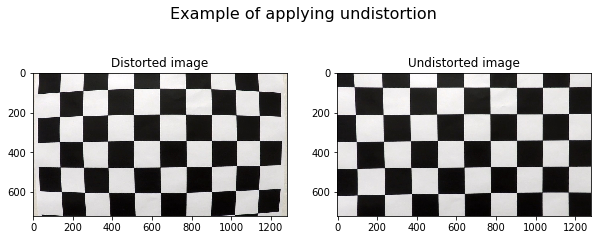

In [2]:
#undistorion
[mtx, dist] = calibrate(calibrate_img_dir, chess_size)

distorted_img = mpimg.imread('camera_cal/calibration1.jpg')

undistorted_img = undistort(distorted_img, mtx, dist)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.imshow(distorted_img)
plt.title('Distorted image')
plt.subplot(122)
plt.imshow(undistorted_img)
plt.title('Undistorted image')

plt.suptitle('Example of applying undistortion',fontsize=16)

plt.savefig("writeup_figures/undistort.jpg")
plt.show()

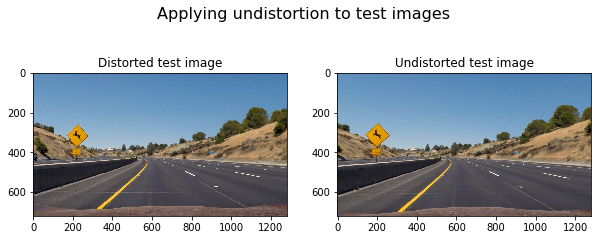

In [3]:
#Undistort test image
input_img_distort = mpimg.imread('test_images/test2.jpg')

input_img = undistort(input_img_distort, mtx, dist)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.imshow(input_img_distort)
plt.title('Distorted test image')
plt.subplot(122)
plt.imshow(input_img)
plt.title('Undistorted test image')

plt.suptitle('Applying undistortion to test images',fontsize=16)

plt.savefig("writeup_figures/undistort_test.jpg")
plt.show()

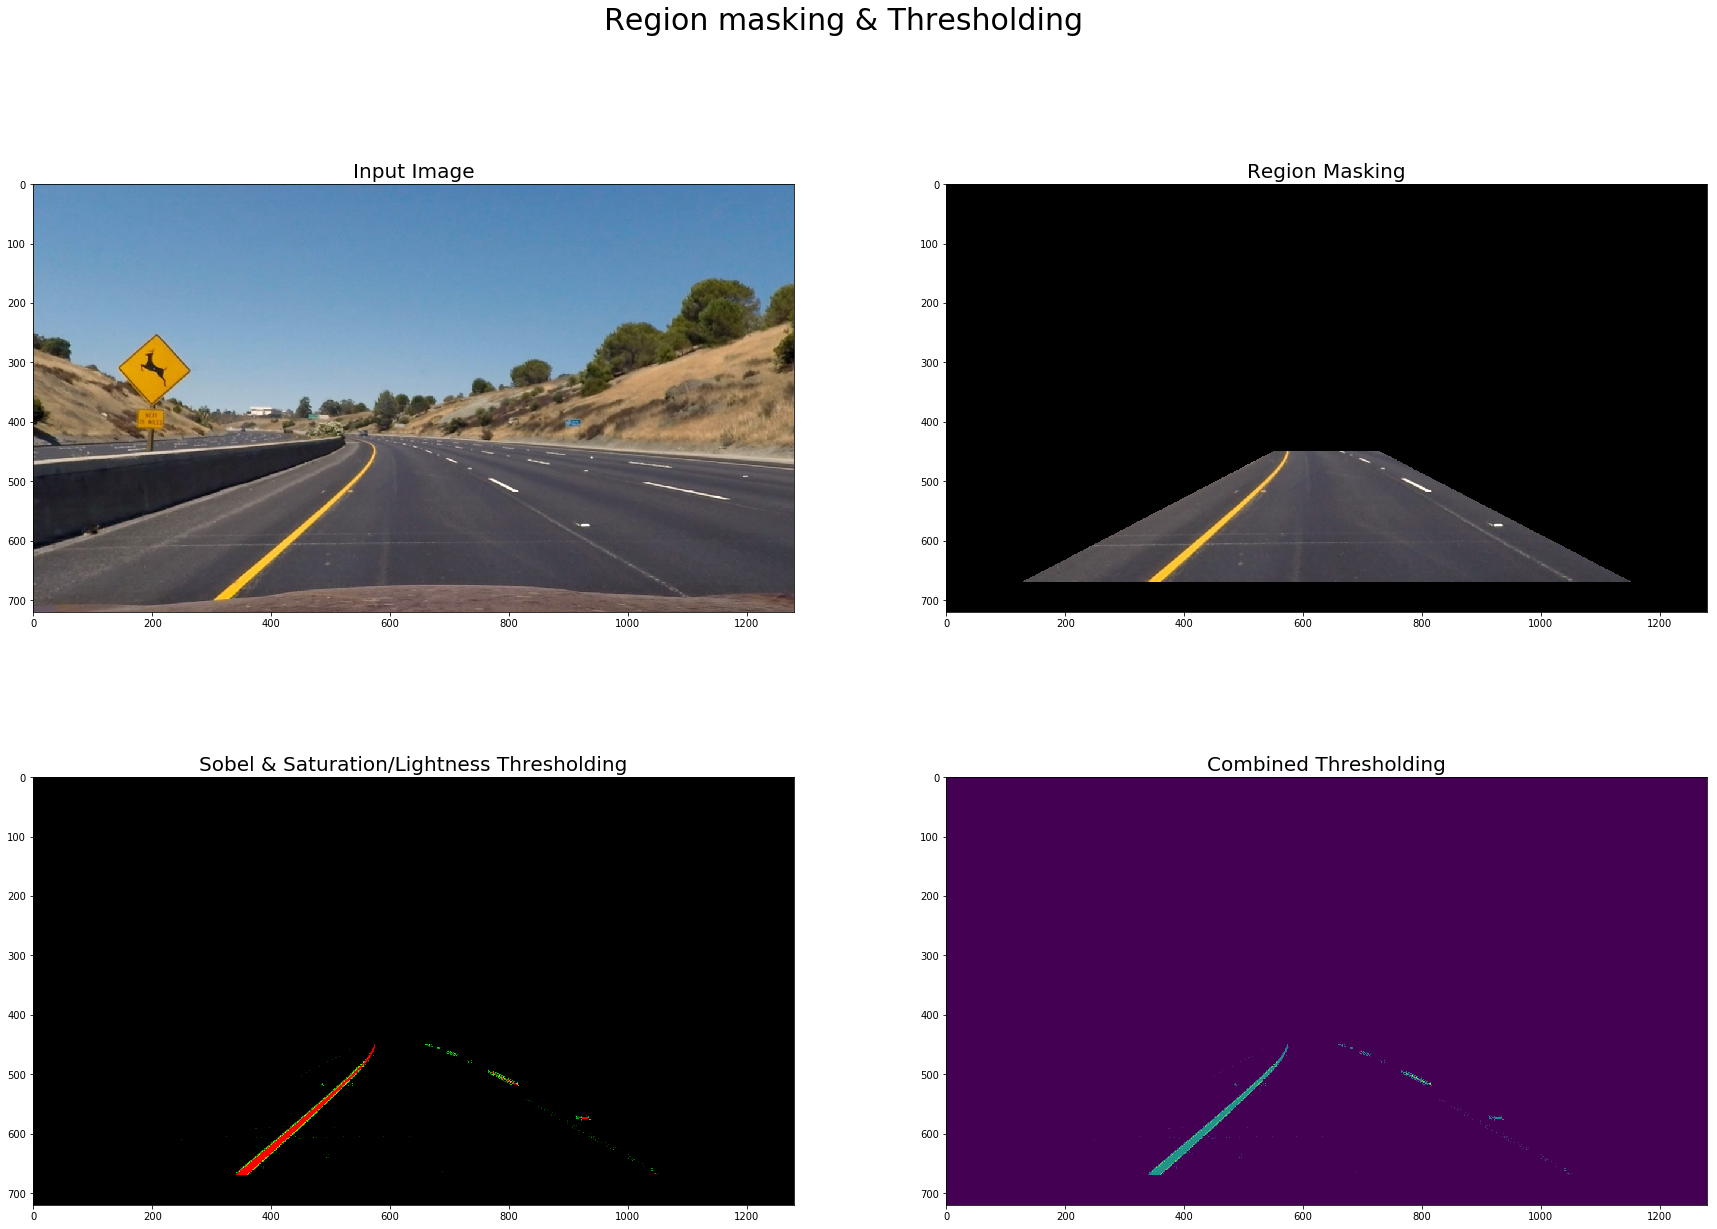

In [7]:
#Thresholding & region masking

thresh_image, color_binary, region_masked_img = threshold(input_img)  


plt.figure(figsize=(30,20))

plt.subplot(2,2,1)
plt.imshow(input_img)
plt.title('Input Image', fontsize=20)
plt.subplot(2,2,2)
plt.imshow(region_masked_img)
plt.title('Region Masking', fontsize=20)
plt.subplot(2,2,3)
plt.imshow(color_binary)
plt.title('Sobel & Saturation/Lightness Thresholding', fontsize=20)
plt.subplot(2,2,4)
plt.imshow(thresh_image)
plt.title('Combined Thresholding', fontsize=20)

plt.suptitle('Region masking & Thresholding',fontsize=30)

plt.savefig("writeup_figures/thresholding.jpg")
plt.show()

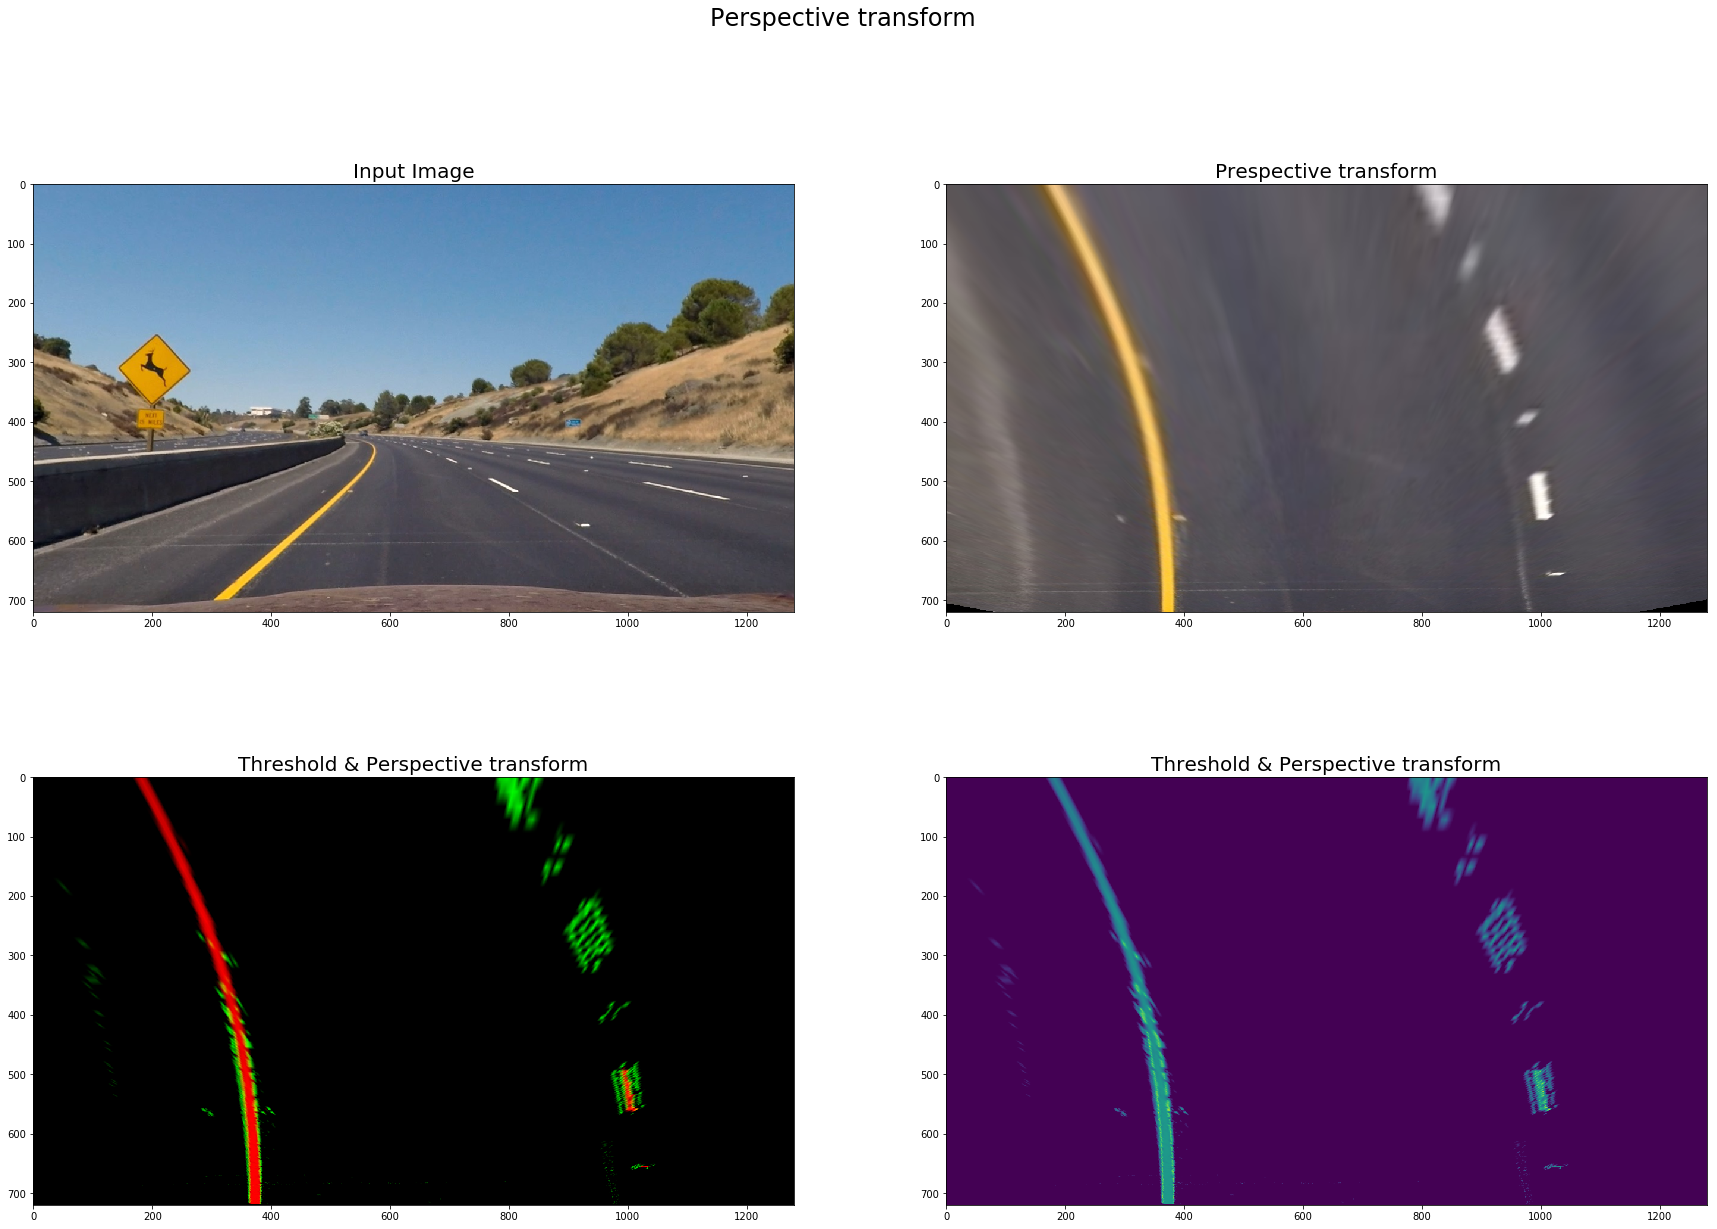

In [8]:
#perspective transform
per_img = perspective_transform(input_img, source_points, destination_points)

per_thresh_img = perspective_transform(thresh_image, source_points, destination_points)

per_color_img = perspective_transform(color_binary, source_points, destination_points)

plt.figure(figsize=(30,20))

plt.subplot(221)
plt.imshow(input_img)
plt.title('Input Image', fontsize=20)
plt.subplot(222)
plt.imshow(per_img)
plt.title('Prespective transform', fontsize=20)
plt.subplot(223)
plt.imshow(per_color_img)
plt.title('Threshold & Perspective transform', fontsize=20)
plt.subplot(224)
plt.imshow(per_thresh_img)
plt.title('Threshold & Perspective transform', fontsize=20)

plt.suptitle('Perspective transform',fontsize=24)

plt.savefig("writeup_figures/per_trans.jpg")
plt.show()

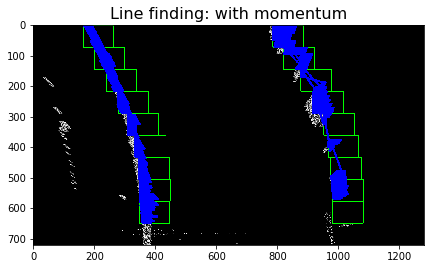

In [116]:
#Line finding
myLine = Line()
myLine.set_param(input_img.shape, 3/110, 3.7/640)

#finding and fitting lane lines
line_finding_img = find_lines(per_thresh_img, myLine, mode='convolution')

plt.figure(figsize=(7,7))
plt.imshow(line_finding_img)
plt.title('Line finding: with momentum', fontsize=16)

plt.savefig("writeup_figures/line_find_momentum.jpg")
plt.show()


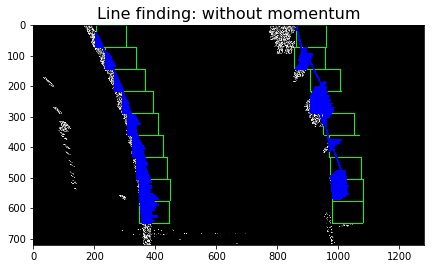

In [111]:
#Line finding without momentum
myLine = Line()
myLine.set_param(input_img.shape, 3/110, 3.7/640)


#finding and fitting lane lines
line_finding_img = find_lines(per_thresh_img, myLine, mode='convolution')

plt.figure(figsize=(7,7))
plt.imshow(line_finding_img)
plt.title('Line finding: without momentum', fontsize=16)

plt.savefig("writeup_figures/line_find_no_momentum.jpg")
plt.show()